In [1]:
import os
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

In [2]:
import reading_util as ru
import string_constants as sc
import quantile_regression_dnn as qr
import loss_strategy as lo
import plotting_util as pu

Using TensorFlow backend.


# Class Definitions

In [3]:
class Parameter():
    
    def __init__(self, val, title_str, path_str):
        self.val = val
        self.title_str = title_str
        self.path_str = path_str
        
    
class Quantile( Parameter ):
    pass


class LossStrategy( Parameter ):
    
    def __call__( self, x ):
        return self.val( x )


# model (change!)

In [4]:
regr_cut = True

In [5]:
fig_dir_base = 'fig/analysis_quantile_regression/regression' + ('_cut' if regr_cut else '_full')
!mkdir -p $fig_dir_base

# read in qcd data

In [6]:
sample = 'qcdSig'
qcd_path = os.path.join( sc.concat_result_dir, sc.sample_loc[sample] + sc.concat_result_suffix )
qcd_data_total, labels = ru.read_results_to_recarray( qcd_path )

In [7]:
print(qcd_data_total.shape)

(4623774,)


In [8]:
# split qcd data in QR train and selection testset
QR_train_share = 0.25 #0.2
qcd_n_evts = qcd_data_total.shape[0]
qcd_data_train = qcd_data_total[:int(qcd_n_evts*QR_train_share)]

# read in signal data and test qcd data

In [9]:
BSM_samples = ['GtoWW15na', 'GtoWW20na', 'GtoWW25na', 'GtoWW30na', 'GtoWW35na', 'GtoWW40na', 'GtoWW45na', \
              'GtoWW15br', 'GtoWW20br', 'GtoWW25br', 'GtoWW30br', 'GtoWW35br', 'GtoWW40br', 'GtoWW45br']
all_samples = ['qcdSig'] + BSM_samples

result_data = {}

for n in all_samples:
    if n == 'qcdSig':
        sample = qcd_data_total[int(qcd_n_evts*QR_train_share):] # all of qcd already read in, take test share
    else:
        sample, labels = ru.read_results_to_recarray( os.path.join( sc.concat_result_dir, sc.sample_loc[n] + sc.concat_result_suffix ) )
    print(n,": ",sample.shape[0],"events")
    result_data[n] = sample

('qcdSig', ': ', 3467831, 'events')
('GtoWW15na', ': ', 448032, 'events')
('GtoWW20na', ': ', 477149, 'events')
('GtoWW25na', ': ', 512505, 'events')
('GtoWW30na', ': ', 530775, 'events')
('GtoWW35na', ': ', 488137, 'events')
('GtoWW40na', ': ', 530031, 'events')
('GtoWW45na', ': ', 432356, 'events')
('GtoWW15br', ': ', 394521, 'events')
('GtoWW20br', ': ', 446043, 'events')
('GtoWW25br', ': ', 472902, 'events')
('GtoWW30br', ': ', 486192, 'events')
('GtoWW35br', ': ', 498566, 'events')
('GtoWW40br', ': ', 503838, 'events')
('GtoWW45br', ': ', 517498, 'events')


# loop over loss strategies and quantiles

In [10]:
loss_strategy_dict = { 's1' : LossStrategy(lo.combine_loss_l1, 'L1 > LT', 'l1_loss'),
                     's2': LossStrategy(lo.combine_loss_l2, 'L2 > LT', 'l2_loss'),
                     's3': LossStrategy(lo.combine_loss_sum, 'L1 + L2 > LT', 'suml1l2_loss'),
                     's4': LossStrategy(lo.combine_loss_max, 'L1 | L2 > LT', 'maxl1l2_loss'),
                     's5': LossStrategy(lo.combine_loss_min, 'L1 & L2 > LT', 'minl1l2_loss')
                 }
#loss_strategies = ['s1','s2','s3','s4','s5']
loss_strategies = ['s1','s2']

In [11]:
quantile_dict = {'q1': Quantile(1e-2, '1% quantile', 'qu_1pct'), 
                  'q2': Quantile(2e-2, '2% quantile', 'qu_2pct'),
                  'q5': Quantile(5e-2, '5% quantile', 'qu_5pct'),
                  'q10': Quantile(1e-10, '10% quantile', 'qu_10pct')
                 }
#quantiles = ['q1','q2','q5','q10']
quantiles = ['q1','q2']

In [12]:
def make_fig_dir( quant, strat ):
    fig_dir_ext = os.path.join(fig_dir_base,strat.path_str,quant.path_str)
    !mkdir -p $fig_dir_ext
    return fig_dir_ext

In [13]:
def plot_qr_2d_hist( qcd_data, loss, model, quantile, strategy, fig_dir ):
    Mjj_selection = 1100.
    plt.figure(figsize=(8, 8))
    x_min = Mjj_selection*0.8
    x_max = 7000. #np.percentile(x, 99.99)
    plt.hist2d(qcd_data['mJJ'], loss,
           range=((x_min , x_max), (np.min(loss), np.percentile(loss, 1e2*(1-1e-4)))), 
           norm=LogNorm(), bins=100, label='signal data')

    xs = np.arange(Mjj_selection, x_max, 0.001*(x_max-Mjj_selection))
    plt.plot(xs, model.predict( xs ) , '-', color='m', lw=2.5, label='GBR selection')
    if regr_cut:
        plt.plot(xs, model.predict(np.minimum(xs,max_acc_mjj)) , '-', color='purple', lw=3, label='GBR selection cut')
    
    plt.ylabel(strategy.title_str)
    plt.xlabel('$M_{jj}$ [GeV]')
    plt.title('qcd signal region '+ quantile.title_str +' QR training data')
    plt.colorbar()
    plt.legend(loc='best')
    plt.draw()
    plt.savefig(os.path.join(fig_dir,'qcd_selection_training_hist2d.png'))

In [14]:
def plot_acc_vs_rej_hist(name, data, selection, fig_dir):
    accepted = data[ selection ]
    rejected = data[ ~selection ]
    xx = [data['mJJ'], accepted['mJJ'], rejected['mJJ']]
    plot_name = name+'_event_selection'
    [h_t, h_a, h_r], _ = \
        pu.plot_hist( xx, xlabel='M_jj', bins=100, title='event selection ' + name, fig_dir=fig_dir, plot_name=plot_name, legend=['total','accepted','rejected'], normed=False)

In [15]:
def print_table( results, quantiles, loss_strategies ):
    
    date = datetime.date.today().strftime("%m%d")
    with open(fig_dir_base+'/eff_tables_'+date+'.txt','w') as f:
        
        for quant in quantiles:
            eff = results[quant]
            table = PrettyTable(['sample'] + [ loss_strategy_dict[l].title_str for l in loss_strategies ])
            for n in all_samples:
                eff_fmt = ['{:.2f}'.format(e) for e in eff[n]]
                table.add_row([n] + eff_fmt)
            table_title = '\n'+'+'*30 + '\n\t' + quantile_dict[quant].title_str + '\n\n'
            print(table_title)
            print(table)
            f.write(table_title)
            f.write(str(table))

In [16]:
from matplotlib.pyplot import cm

def plot_eff_vs_mjj( analysis, quantiles, loss_strategies ):
    
    for q in quantiles:
        
        eff = analysis[q]
    
        narrows = np.array( [ eff[k] for k in BSM_samples if 'na' in k ] )
        broads = np.array( [ eff[k] for k in BSM_samples if 'br' in k ] )

        color = cm.jet(np.linspace(0,1,len(loss_strategies)))

        plt.figure(figsize=(8, 8))

        xx = [1.5,2.0,2.5,3.0,3.5,4.0,4.5]

        for i, strat in enumerate([ loss_strategy_dict[l].title_str for l in loss_strategies ]):
            plt.plot( xx, narrows[:,i], label='narrow ' + strat, color=color[i], linestyle='-', lw=1.5 )
            plt.plot( xx, broads[:,i], label='broad ' + strat, color=color[i], linestyle='dashed', lw=1.5 )      

        plt.ylabel('efficiency %')
        plt.xlabel('$M_{jj}$ [GeV]')
        plt.title('sample efficiency '+ quantile_dict[q].title_str)
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.draw()
        plt.savefig(os.path.join(fig_dir_base,'efficiency_plt_'+quantile_dict[q].path_str+'.png'), bbox_inches="tight")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

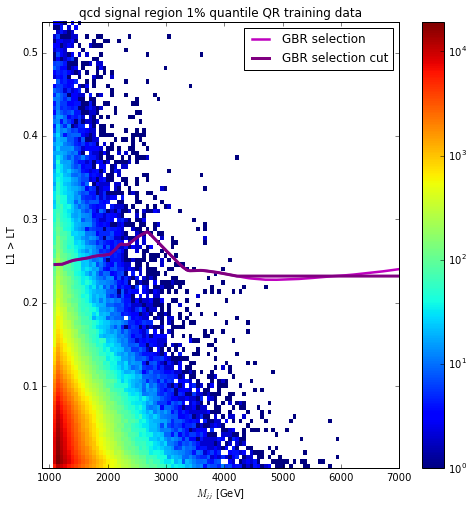

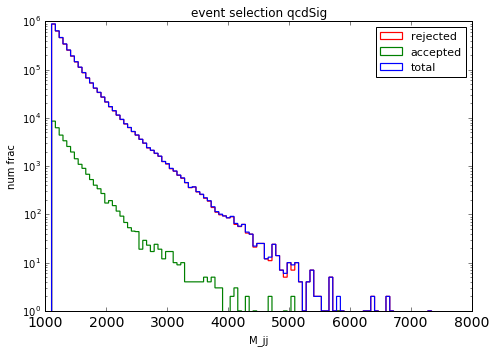

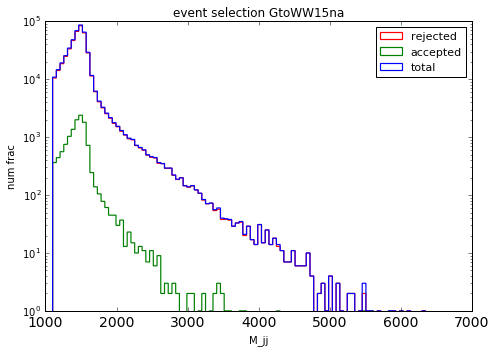

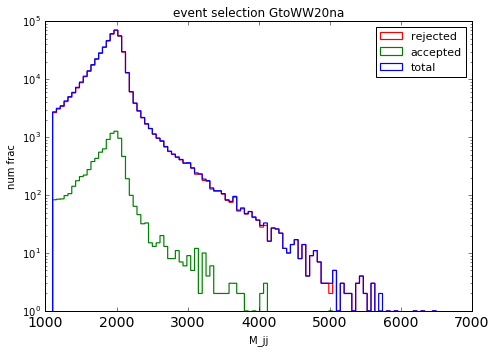

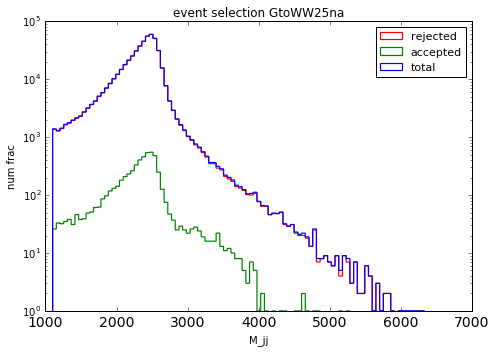

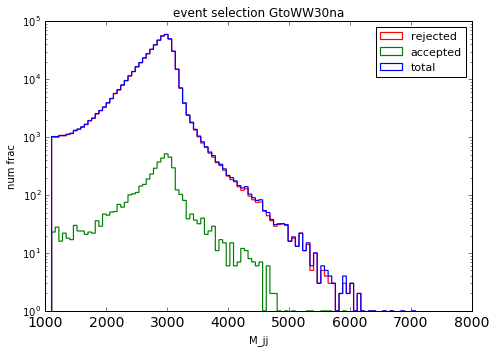

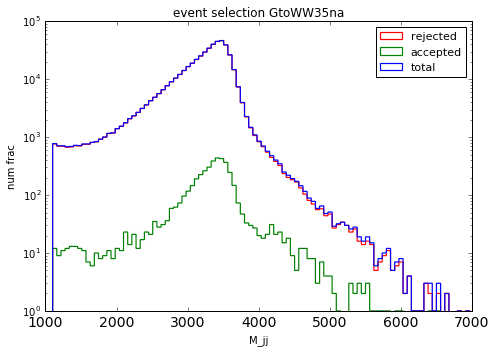

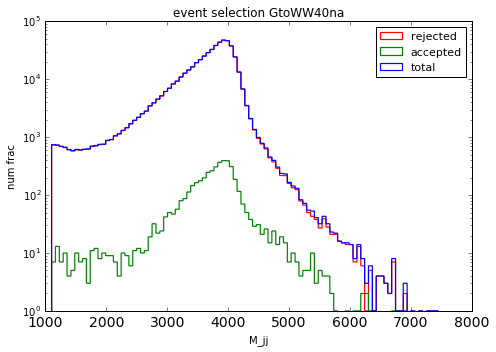

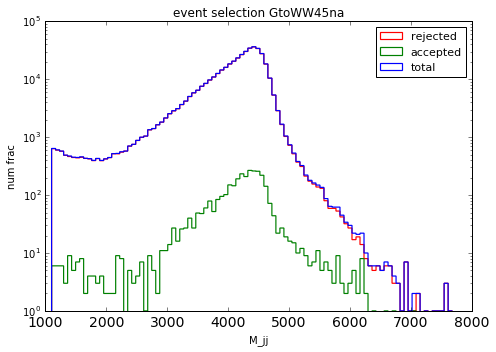

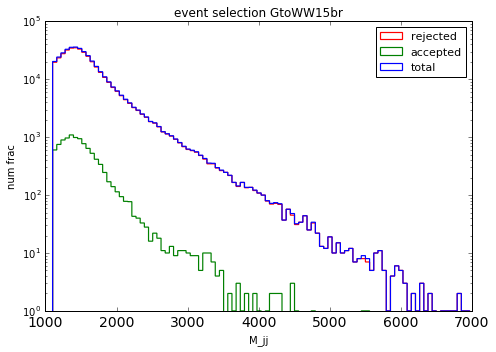

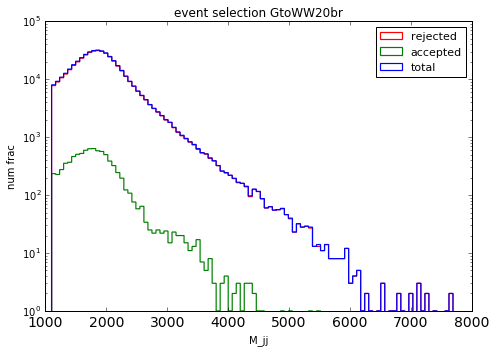

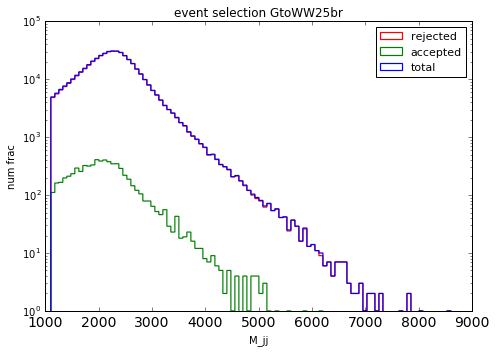

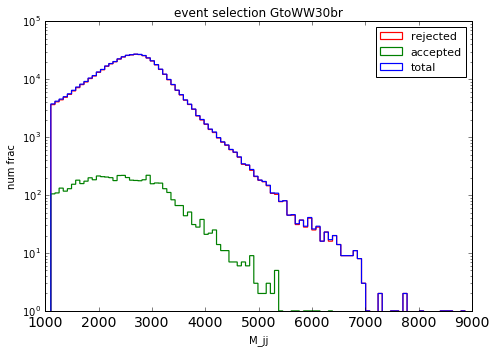

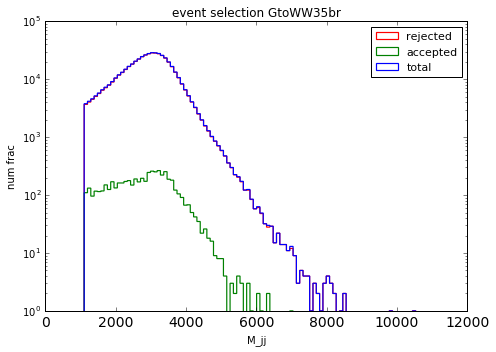

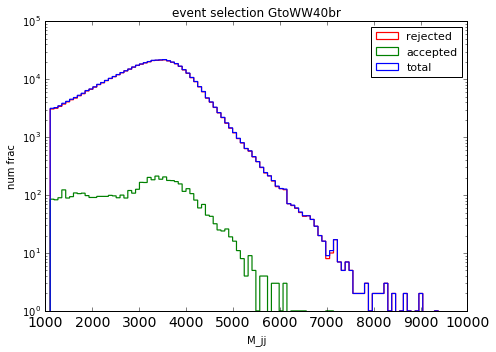

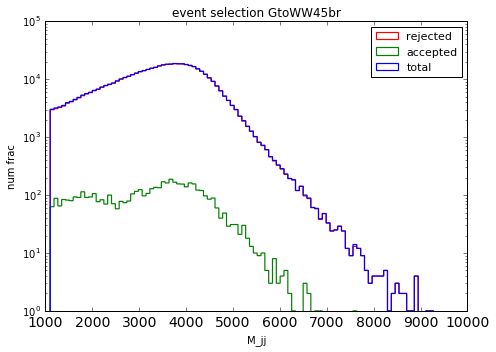

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total para

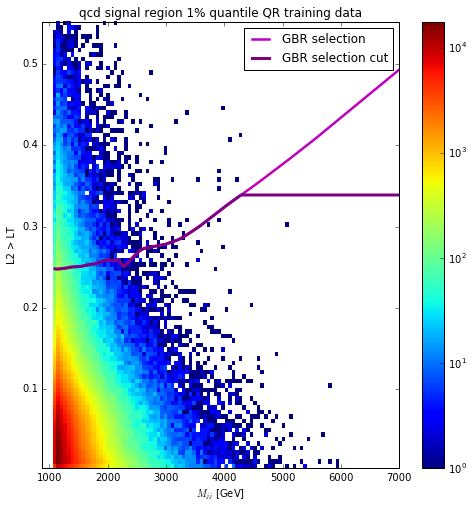

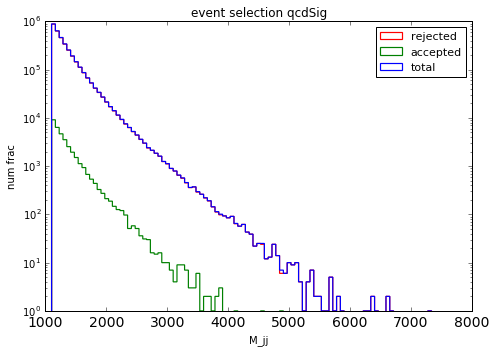

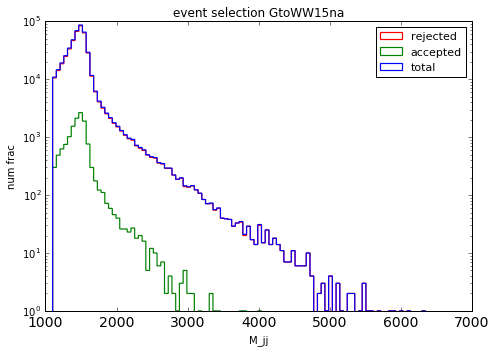

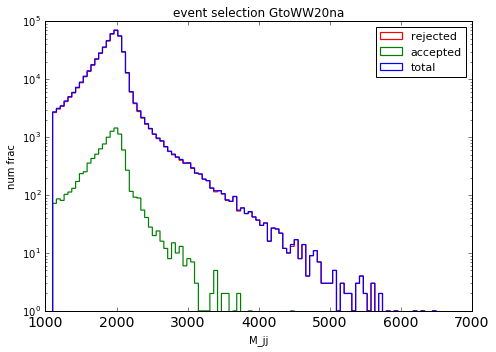

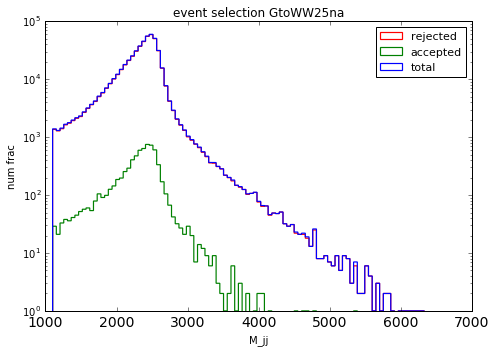

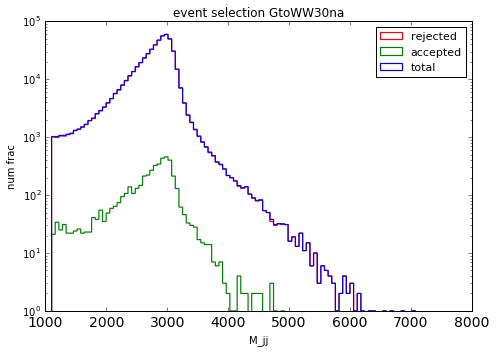

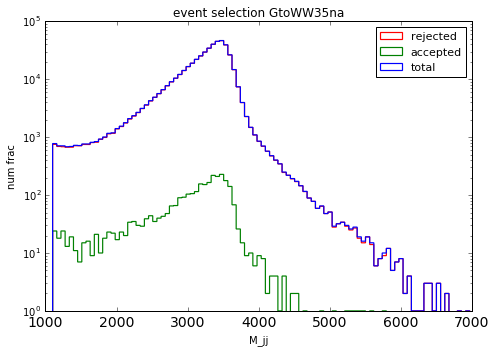

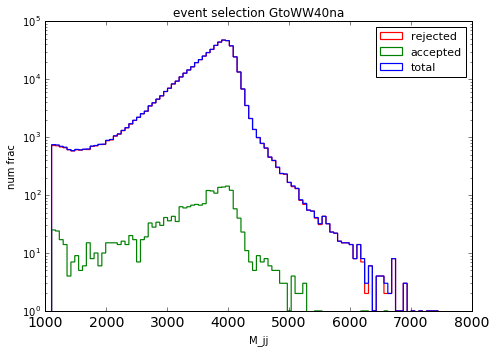

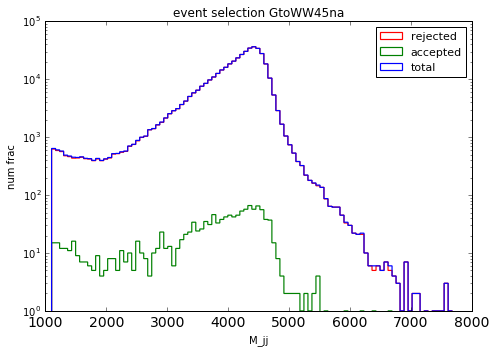

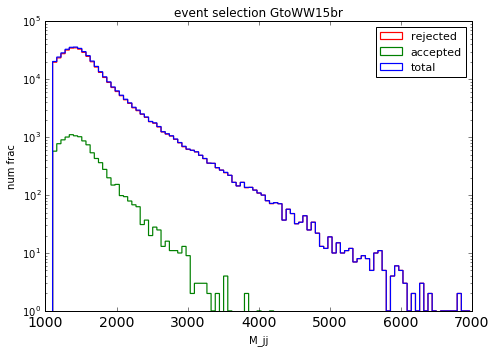

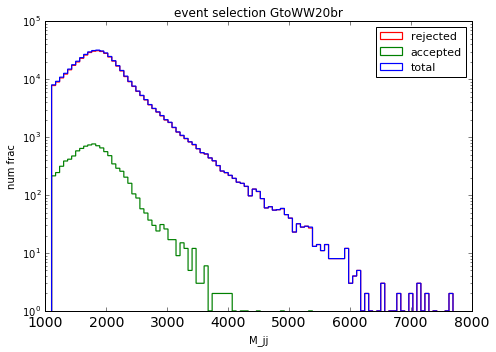

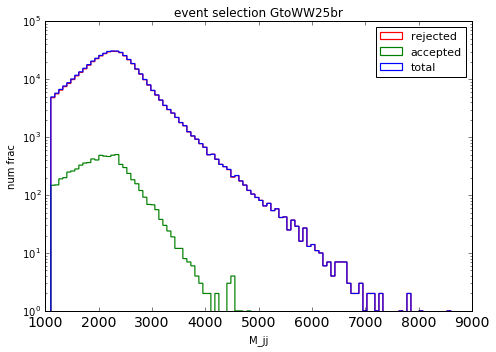

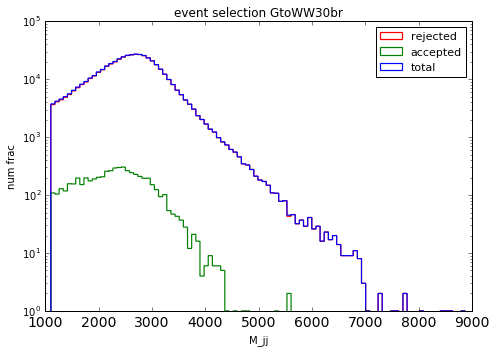

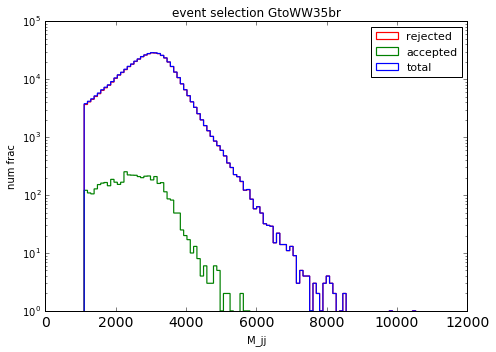

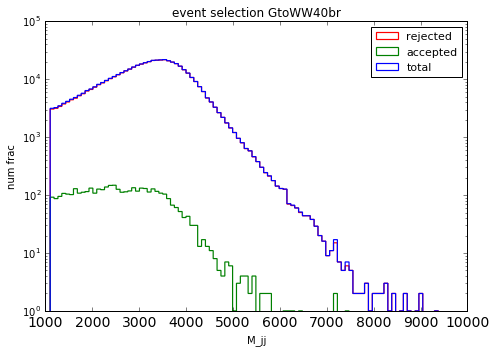

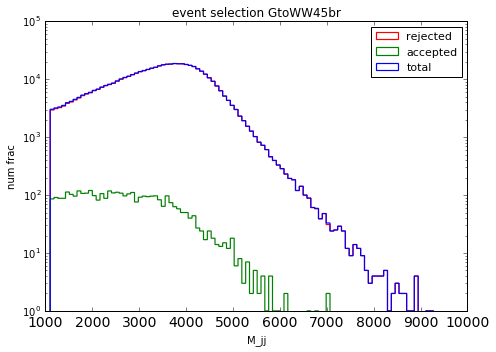

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total para

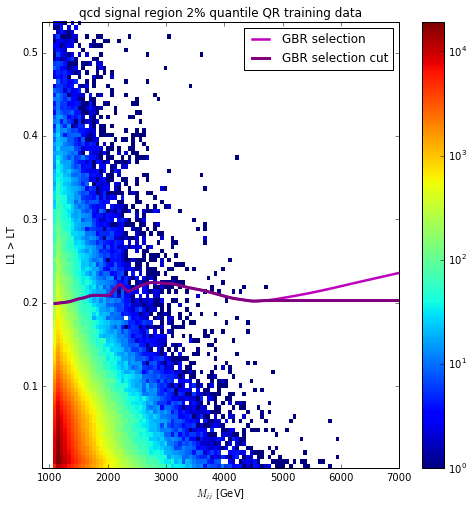

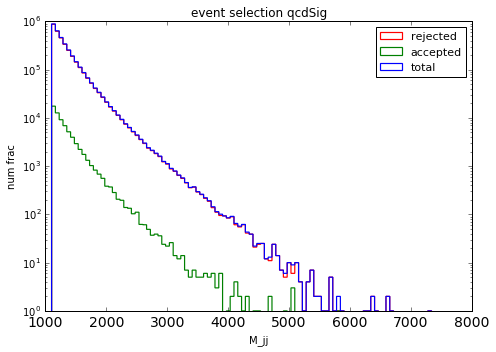

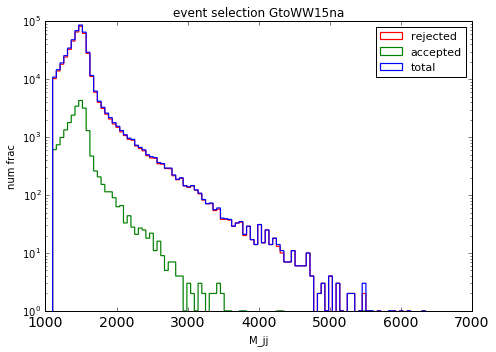

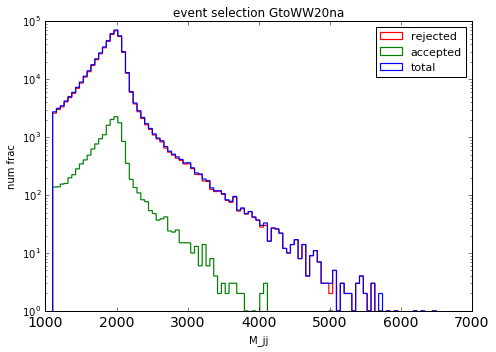

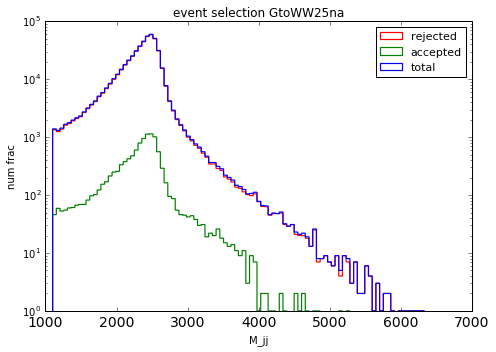

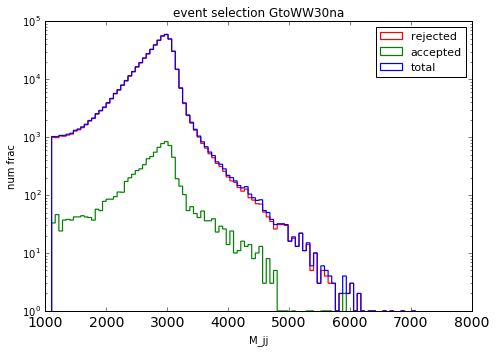

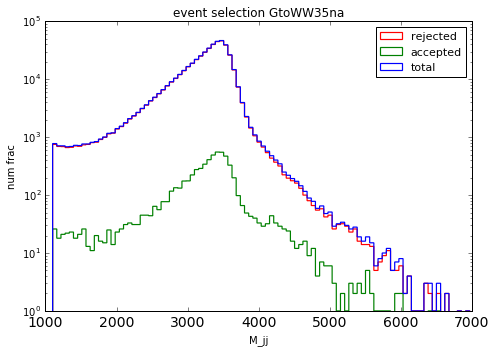

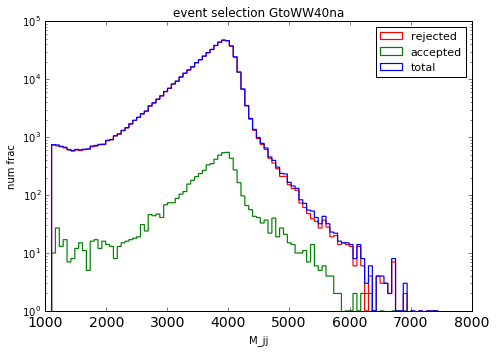

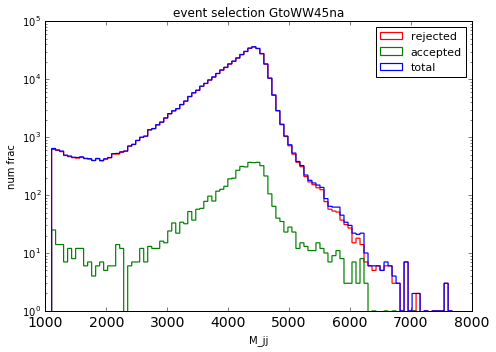

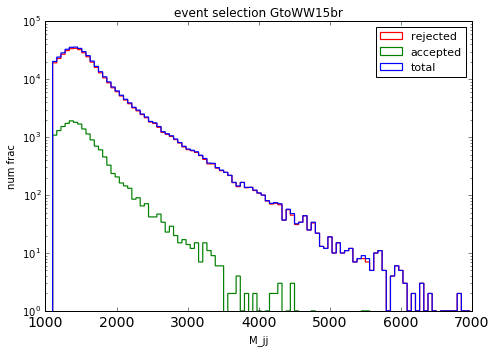

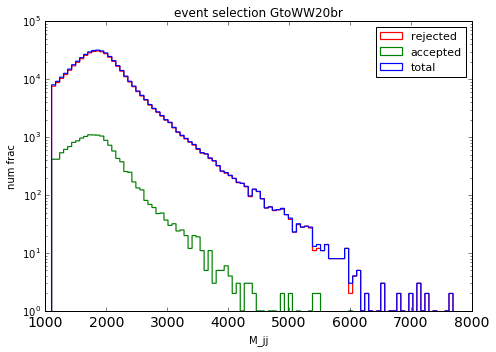

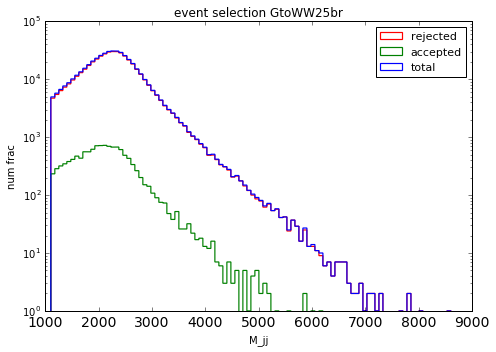

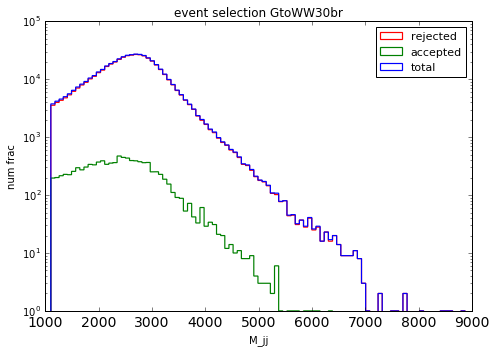

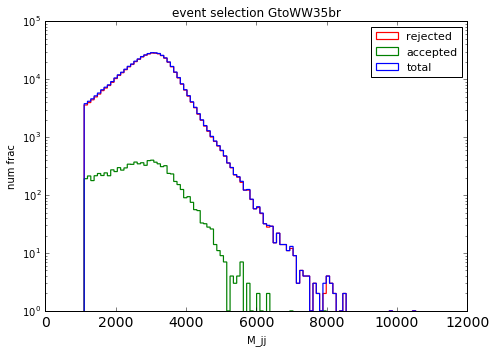

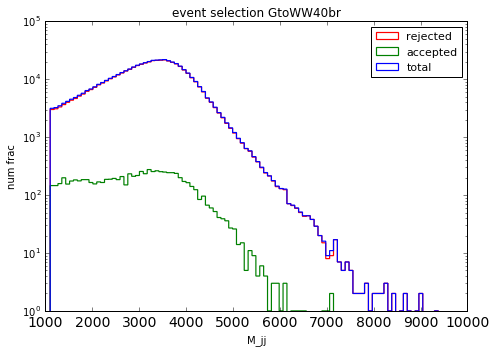

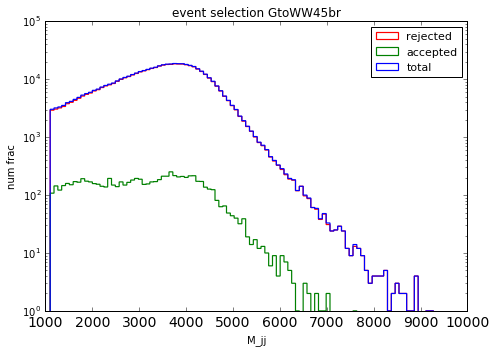

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               200       
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total para

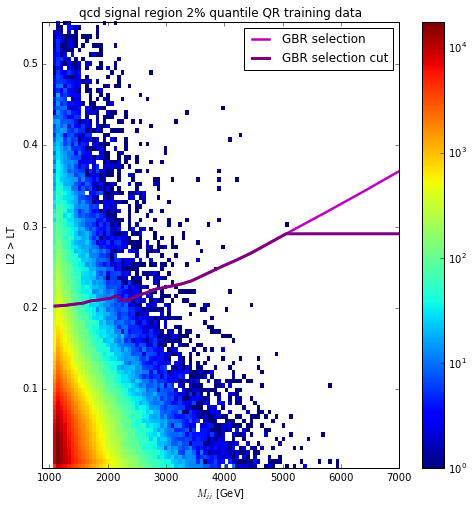

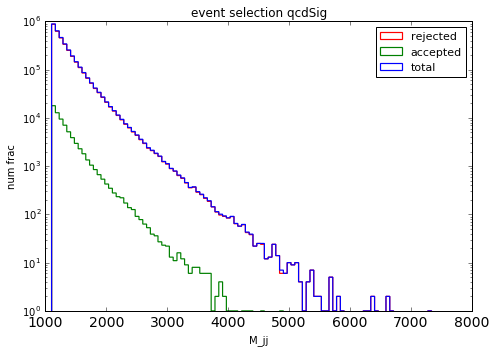

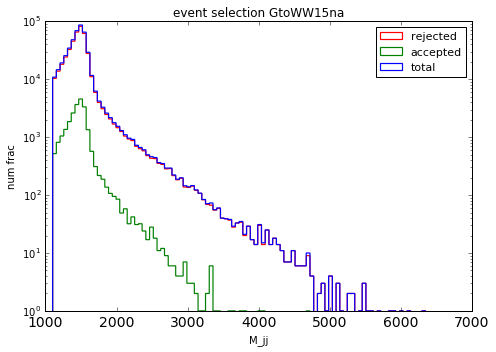

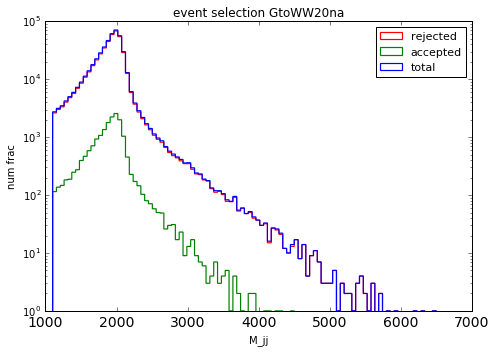

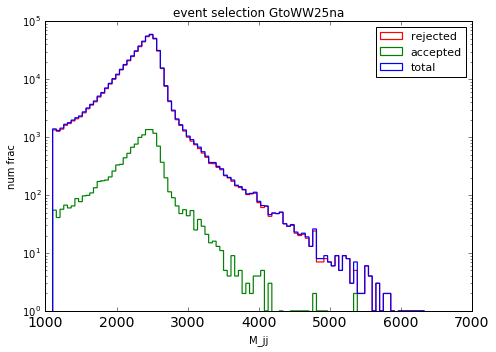

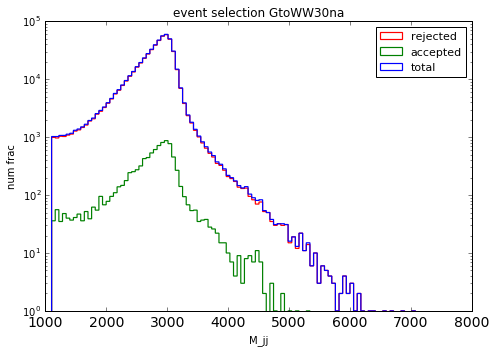

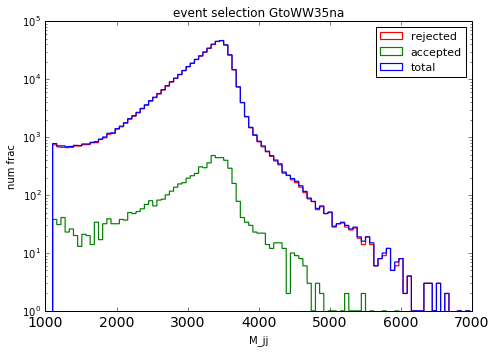

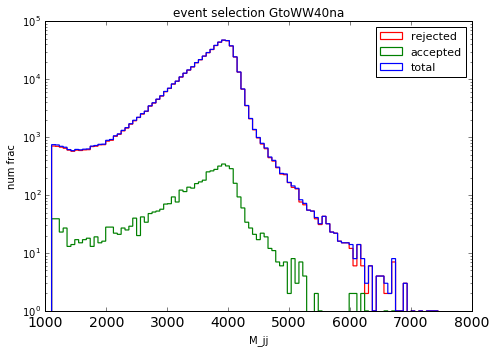

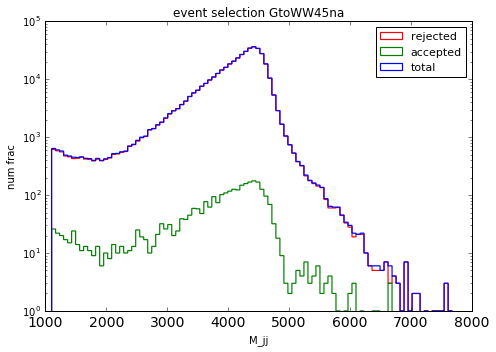

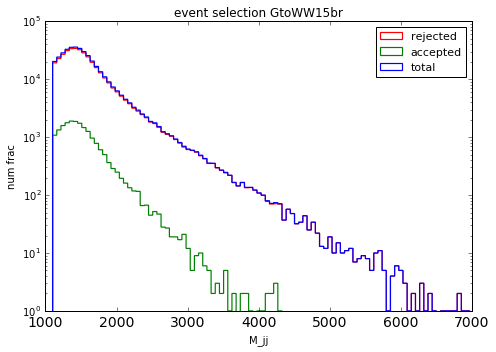

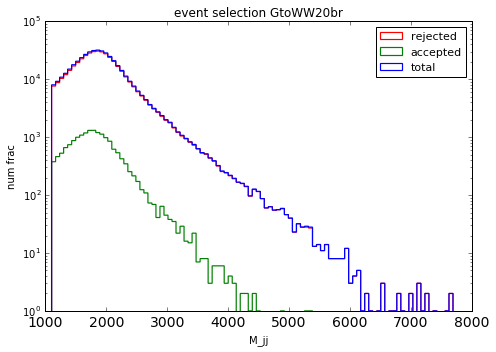

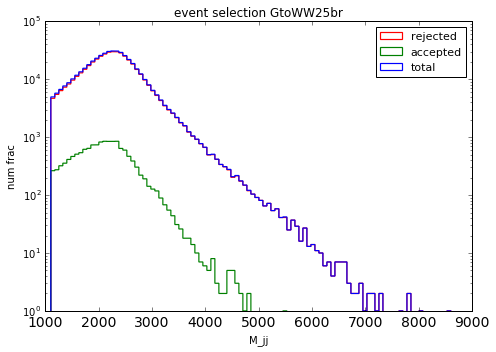

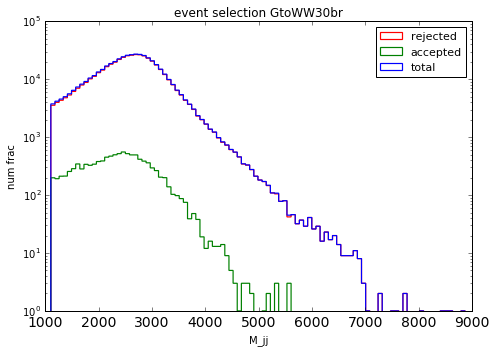

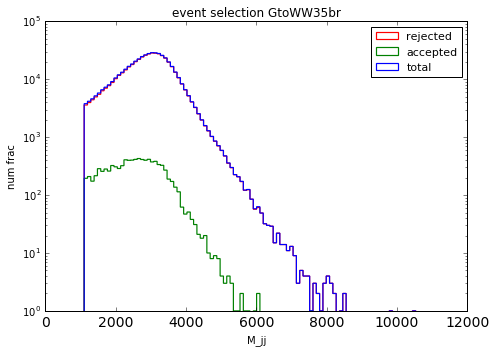

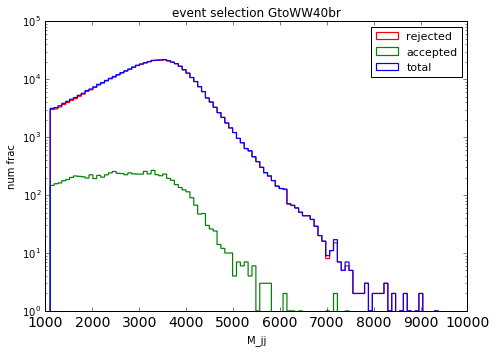

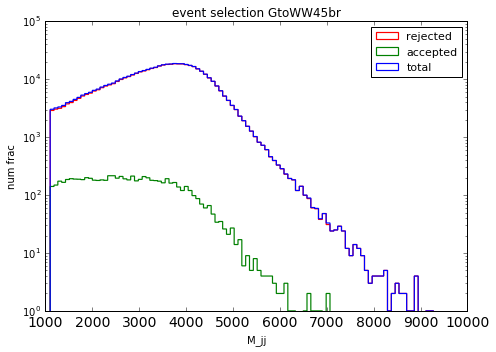

In [17]:
analysis = {}

for q in quantiles: ### for each quantile
    
    quantile = quantile_dict[q]
    eff = {} # key: dataset, values: list for all loss strategies
    
    for s in loss_strategies: ### for each loss strategy
        
        strategy = loss_strategy_dict[s]
        
        # train QR
        model = qr.Quantile_Regression( quantile.val )
        y = strategy(qcd_data_train)
        model.fit( qcd_data_train['mJJ'], y )
        
        # get overflow bin (max accepted mjj) for regression cut
        sel = model.select_events( qcd_data_train['mJJ'], y ) # get selection for qcd training set
        max_acc_mjj = np.max(qcd_data_train['mJJ'][sel]) # get max mjj in accepted set
        
        # plot results
        fig_dir_ext = make_fig_dir( quantile, strategy )
        plot_qr_2d_hist( qcd_data_train, y, model, quantile, strategy, fig_dir_ext )
        
        # apply trained model to test datasets
        for n in all_samples:
            x = result_data[n]['mJJ']
            y = strategy(result_data[n])
            if regr_cut:
                sel = model.select_events_regression_cut( x, y, max_acc_mjj )
            else:
                sel = model.select_events( x, y )    
            eff.setdefault(n,[]).append(100.0*np.sum(sel)/float(sel.shape[0])) # add efficiency for sample n and quantile q
            plot_acc_vs_rej_hist(n, result_data[n], sel, fig_dir_ext )
            
    analysis[q] = eff 



++++++++++++++++++++++++++++++
	 quantile 1% quantile


+-----------+---------+---------+
|   sample  | L1 > LT | L2 > LT |
+-----------+---------+---------+
|   qcdSig  |   0.98  |   1.02  |
| GtoWW15na |   2.77  |   2.98  |
| GtoWW20na |   1.87  |   2.14  |
| GtoWW25na |   1.11  |   1.40  |
| GtoWW30na |   0.91  |   0.89  |
| GtoWW35na |   0.91  |   0.61  |
| GtoWW40na |   0.85  |   0.41  |
| GtoWW45na |   0.76  |   0.30  |
| GtoWW15br |   2.59  |   2.74  |
| GtoWW20br |   1.88  |   2.18  |
| GtoWW25br |   1.39  |   1.60  |
| GtoWW30br |   1.14  |   1.16  |
| GtoWW35br |   1.08  |   0.95  |
| GtoWW40br |   1.02  |   0.80  |
| GtoWW45br |   0.98  |   0.71  |
+-----------+---------+---------+

++++++++++++++++++++++++++++++
	 quantile 2% quantile


+-----------+---------+---------+
|   sample  | L1 > LT | L2 > LT |
+-----------+---------+---------+
|   qcdSig  |   1.99  |   2.03  |
| GtoWW15na |   4.90  |   5.20  |
| GtoWW20na |   3.32  |   3.79  |
| GtoWW25na |   2.14  |   2.53  |
| 

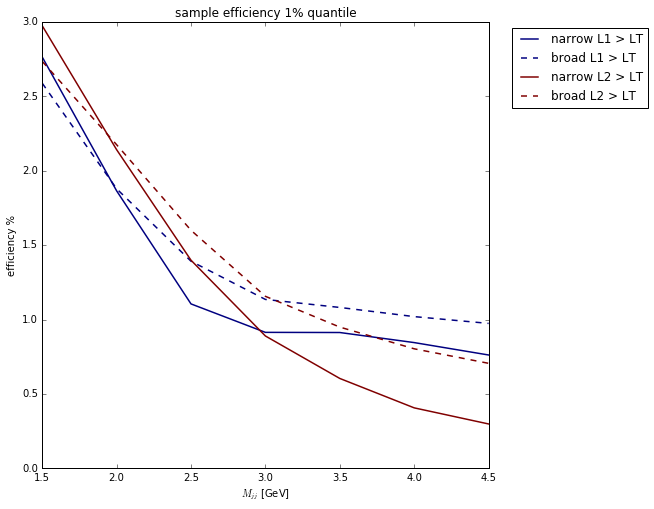

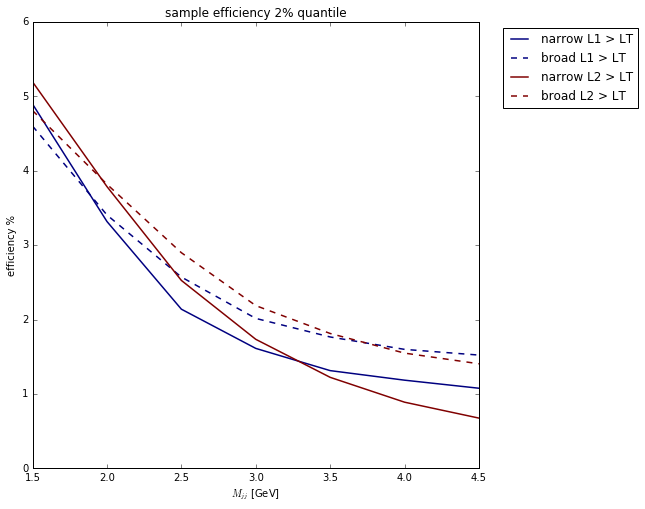

In [18]:
# print table for all quantiles
print_table( analysis, quantiles, loss_strategies ) # pass quantiles and loss strategies because dict not ordered 
# print graph for all quantiles
plot_eff_vs_mjj( analysis, quantiles, loss_strategies )


++++++++++++++++++++++++++++++
	 quantile 10% quant


+-----------+--------------+--------------+--------------+---------+---------+
|   sample  | L1 & L2 > LT | L1 | L2 > LT | L1 + L2 > LT | L1 > LT | L2 > LT |
+-----------+--------------+--------------+--------------+---------+---------+
|   qcdSig  |    10.03     |    10.04     |    10.02     |  10.01  |  10.02  |
| GtoWW15na |    24.37     |    19.78     |    22.85     |  18.62  |  18.85  |
| GtoWW20na |    21.73     |    15.51     |    18.77     |  16.07  |  16.55  |
| GtoWW25na |    19.38     |    11.64     |    14.51     |  13.58  |  13.49  |
| GtoWW30na |    16.39     |     8.87     |    10.93     |  11.92  |  10.91  |
| GtoWW35na |    14.63     |     7.50     |     9.07     |  11.72  |   9.55  |
| GtoWW40na |    13.04     |     6.95     |     8.10     |  11.40  |   8.99  |
| GtoWW45na |    11.72     |     7.40     |     8.08     |  11.62  |   9.07  |
| GtoWW15br |    23.70     |    18.74     |    21.98     |  18.10  |  18.21 

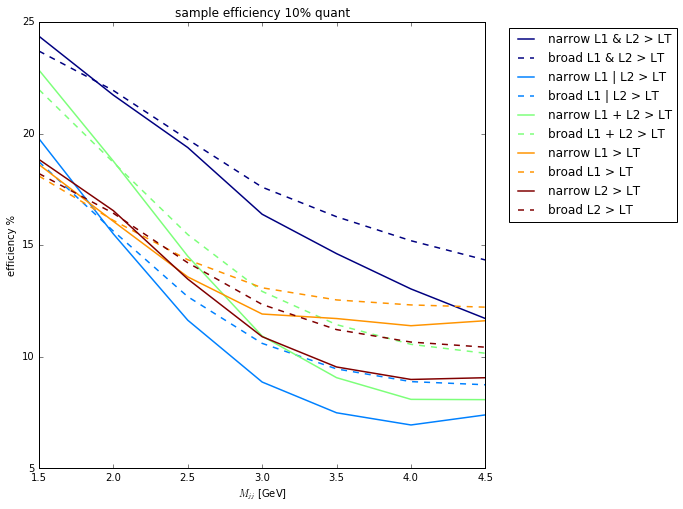

In [32]:
# print table for all quantiles
print_table( eff, quantiles_str[j] )
# print graph for all quantiles
plot_eff_vs_mjj( eff, quantiles_str[j] )

In [30]:
narrows[:,1]

array([19.77738197, 15.50983026, 11.64456932,  8.87381659,  7.49646103,
        6.95034819,  7.40130818])

In [23]:
eff

{'GtoWW15br': [23.701653397411036,
  18.743488939752257,
  21.977030373541584,
  18.103218840061746,
  18.21449301811564],
 'GtoWW15na': [24.367455896007428,
  19.777381972716235,
  22.851269552174845,
  18.617643382615526,
  18.84686808085137],
 'GtoWW20br': [21.93488071777833,
  15.63683322011555,
  18.715235975006895,
  16.115935010750086,
  16.43496254845385],
 'GtoWW20na': [21.728851993821635,
  15.509830262664282,
  18.77149485800033,
  16.072966725278686,
  16.5518527755481],
 'GtoWW25br': [19.741299465851277,
  12.69776824796681,
  15.482911892950337,
  14.352868036083587,
  14.218379283657079],
 'GtoWW25na': [19.380493848840498,
  11.644569321274915,
  14.512248660988673,
  13.584257714558882,
  13.487478170944673],
 'GtoWW30br': [17.604567742784745,
  10.606920722677462,
  12.934396287886267,
  13.096266495540856,
  12.34923651561523],
 'GtoWW30na': [16.391691394658753,
  8.87381658895012,
  10.934199990579813,
  11.920870425321464,
  10.905751024445387],
 'GtoWW35br': [16.27

In [21]:
narrows = np.array( [ eff[k] for k in BSM_samples if 'na' in k ] )

In [24]:
narrows[-1,:]

array([11.71974021,  7.40130818,  8.08454144, 11.62051643,  9.06775898])